In [35]:
import numpy as np
import os
import math
from PIL import Image
import pandas as pd
import cv2

# Clustering
from sklearn.cluster import AgglomerativeClustering # 1) Agglomerative-Hierarchical
from sklearn.cluster import KMeans                  # 2) K-Means
from sklearn.mixture import GaussianMixture         # 3) Gaussian Mixture Models
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
# Evaluation
from sklearn import metrics
from skimage.external import tifffile
from skimage.measure import compare_mse
from skimage.metrics import structural_similarity as ssim

from sklearn.decomposition import PCA, KernelPCA               # 2) PCA
from sklearn.manifold import TSNE

# Load Autoencoder                                  # 3) Autoencoder (Deep dimensionality reduction)
from keras.models import load_model
from keras.models import Model

import matplotlib.pyplot as plt 
%matplotlib inline

import newscripts as myutils

In [36]:
import shutil

def symlink_rel(src, dst):
    rel_path_src = os.path.relpath(src, os.path.dirname(dst))
    os.symlink(rel_path_src, dst)
    
def clusterintoDirectories(labels, path, imagenamesList):
    # remove existing subdirectories first to avoid overlap
    sub_directories = [str(i) for i in range(8)]

    for cluster in sub_directories:
        if (cluster in os.listdir(path)) and (os.path.isdir(os.path.join(path , cluster))):
            shutil.rmtree(os.path.join(path , cluster))

    for filename in os.listdir(path):
        if filename.endswith('.tif'):
            for cluster in sub_directories: # count of distinct elements = no. of clusters
                os.makedirs(path + '/{}'.format(cluster) , exist_ok=True)
    
    
    for i in range(len(imagenamesList)):
        # if there isnt already a symlink of this image in the coressponding subdirectory
        if imagenamesList[i] not in os.listdir(path + '/' + sub_directories[labels[i]]): 
            symlink_rel(path + '/{}'.format(imagenamesList[i]) , 
                       path + '/{}'.format(labels[i]) + '/' + imagenamesList[i])

In [37]:
# Load training data

train_directory = "../../Data/Kather_all_train"

X_train = []
train_image_names = []

for filename in os.listdir(train_directory):
    if filename.endswith('tif'):
        image = cv2.imread(os.path.join(train_directory, filename), cv2.IMREAD_UNCHANGED)
        resized_image = cv2.resize(image, (144, 144)) 
        X_train.append(np.asarray( resized_image, dtype="uint8" ))
        train_image_names.append(filename)

y_train = myutils.loadLabelsFromsubdirectoryindex(train_image_names, "../../Data/Kather_original_train")

# Load testing data

test_directory = "../../Data/Kather_all_test"

X_test = []
test_image_names = []

for filename in os.listdir(test_directory):
    if filename.endswith('tif'):
        image = cv2.imread(os.path.join(test_directory, filename), cv2.IMREAD_UNCHANGED)
        resized_image = cv2.resize(image, (144, 144)) 
        X_test.append(np.asarray( resized_image, dtype="uint8" ))
        test_image_names.append(filename)

y_test = myutils.loadLabelsFromsubdirectoryindex(test_image_names, "../../Data/Kather_original_test")

In [2]:
# Load training data

train_directory = "../../Data/Kather_all_train"

X_train = []
train_image_names = []

for filename in os.listdir(train_directory):
    if filename.endswith('tif'):
        image = cv2.imread(os.path.join(train_directory, filename), cv2.IMREAD_UNCHANGED)
        resized_image = cv2.resize(image, (96, 96)) 
        X_train.append(np.asarray( resized_image, dtype="uint8" ))
        train_image_names.append(filename)

y_train = myutils.loadLabelsFromsubdirectoryindex(train_image_names, "../../Data/Kather_original_train")

# Load testing data

test_directory = "../../Data/Kather_all_test"

X_test = []
test_image_names = []

for filename in os.listdir(test_directory):
    if filename.endswith('tif'):
        image = cv2.imread(os.path.join(test_directory, filename), cv2.IMREAD_UNCHANGED)
        resized_image = cv2.resize(image, (96, 96)) 
        X_test.append(np.asarray( resized_image, dtype="uint8" ))
        test_image_names.append(filename)

y_test = myutils.loadLabelsFromsubdirectoryindex(test_image_names, "../../Data/Kather_original_test")

In [38]:
X_train = np.asarray(X_train)
X_test = np.asarray(X_test)

# Normalise
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

In [39]:
CAER_MSE_KATHER = load_model('../Autoencoders/SavedModels/weights/finalists/CAER_MSE_KATHER.h5', compile=False) # 6 x 6 x 16
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 144, 144, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 144, 144, 16)      448       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 144, 144, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 144, 144, 32)      4640      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 144, 144, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 144, 144, 32)      128       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 72, 72, 64)        1849

In [ ]:
layer_name = 'conv2d_7' # 6 x 6 x 32

encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer(layer_name).output)

In [6]:
autoencoder = load_model('../Autoencoders/SavedModels/23FebruarySSIM_epochs1000_batch16_adam_BEST.h5', compile=False) # 6 x 6 x 16
layer_name = 'conv2d_7' # 6 x 6 x 32

encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer(layer_name).output)
# autoencoder.summary()

In [28]:
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 144, 144, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 144, 144, 16)      448       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 144, 144, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 144, 144, 32)      4640      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 144, 144, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 144, 144, 32)      128       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 72, 72, 64)        1849

In [11]:
X_train_enc = encoder.predict(X_train)
print(X_train_enc.shape)

X_test_enc = encoder.predict(X_test)
print(X_test_enc.shape)

X_train_enc = X_train_enc.reshape(X_train_enc.shape[0] , -1) # Reshape for scaling
X_train_enc = StandardScaler().fit_transform(X_train_enc) # Scale

X_test_enc = X_test_enc.reshape(X_test_enc.shape[0] , -1) # Reshape for scaling
X_test_enc = StandardScaler().fit_transform(X_test_enc) # Scale

# Evaluate on testing data using grid search  cv
parameters = {'covariance_type':('full', 'spherical', 'diag', 'tied'), 'n_components':[8],'random_state':[0,19,42]}
clf = GridSearchCV(GaussianMixture(), parameters, scoring=make_scorer(metrics.completeness_score))

clf.fit(X_train_enc, y_train)
print(clf.best_estimator_)
print(clf.best_score_)

parameters = {'init':('k-means++', 'random'), 'n_clusters':[8],'random_state':[0,19,42]}
clf2 = GridSearchCV(KMeans(), parameters, scoring=make_scorer(metrics.completeness_score))

clf2.fit(X_train_enc, y_train)
print(clf2.best_estimator_)
clf2.best_score_

(4200, 9, 9, 16)
(800, 144, 144, 3)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


GaussianMixture(covariance_type='diag', init_params='kmeans', max_iter=100,
                means_init=None, n_components=8, n_init=1, precisions_init=None,
                random_state=0, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)
0.5669664490712942
KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300, n_clusters=8,
       n_init=10, n_jobs=None, precompute_distances='auto', random_state=0,
       tol=0.0001, verbose=0)


0.5437938574287255

In [12]:
# best estimator

gmm_best = GaussianMixture(covariance_type='diag', init_params='kmeans', max_iter=100,
                means_init=None, n_components=8, n_init=1, precisions_init=None,
                random_state=0, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None).fit(X_train_enc)

gmm_labels = gmm_best.predict(X_test_enc)
print(metrics.completeness_score(y_test,gmm_labels))


0.6540563608936277


In [27]:
gmm_labels = gmm_best.predict(X_train_enc)
print(metrics.completeness_score(y_train,gmm_labels))

0.6063290963229739


In [14]:
set(gmm_labels)

{1, 2, 3, 4, 5, 6, 7}

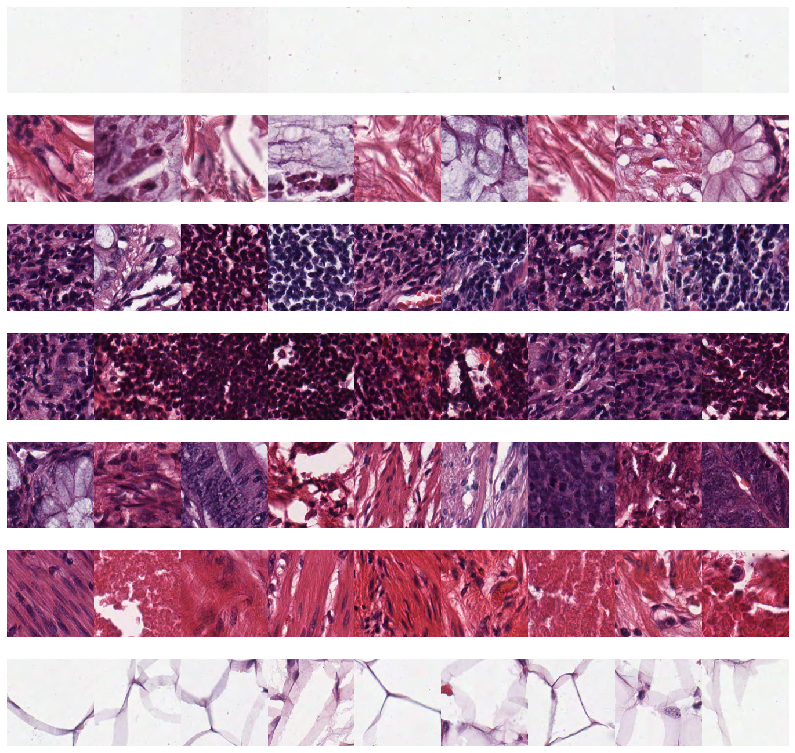

In [16]:
clusterintoDirectories(gmm_labels, test_directory, test_image_names)
myutils.pltPathologyClusters(gmm_labels, test_directory)

In [ ]:
# best estimator

gmm_best = GaussianMixture(covariance_type='diag', init_params='kmeans', max_iter=100,
                means_init=None, n_components=8, n_init=1, precisions_init=None,
                random_state=0, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None).fit(X_train_enc)

gmm_labels = gmm_best.predict(X_test_enc)
print(metrics.completeness_score(y_test,gmm_labels))


In [25]:
def fit_best(estimator, true_labels, data_train, data_test):
    print(estimator)
    esti_best = estimator.fit(data_train)
    pred_labels = esti_best.predict(data_test)
    print("number of distinct predicted classes is {}".format(len(set(pred_labels))))
    print(metrics.completeness_score(true_labels , pred_labels))
    return pred_labels

KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300, n_clusters=8,
       n_init=10, n_jobs=None, precompute_distances='auto', random_state=0,
       tol=0.0001, verbose=0)
number of distinct predicted classes is 8
0.5396558958825681


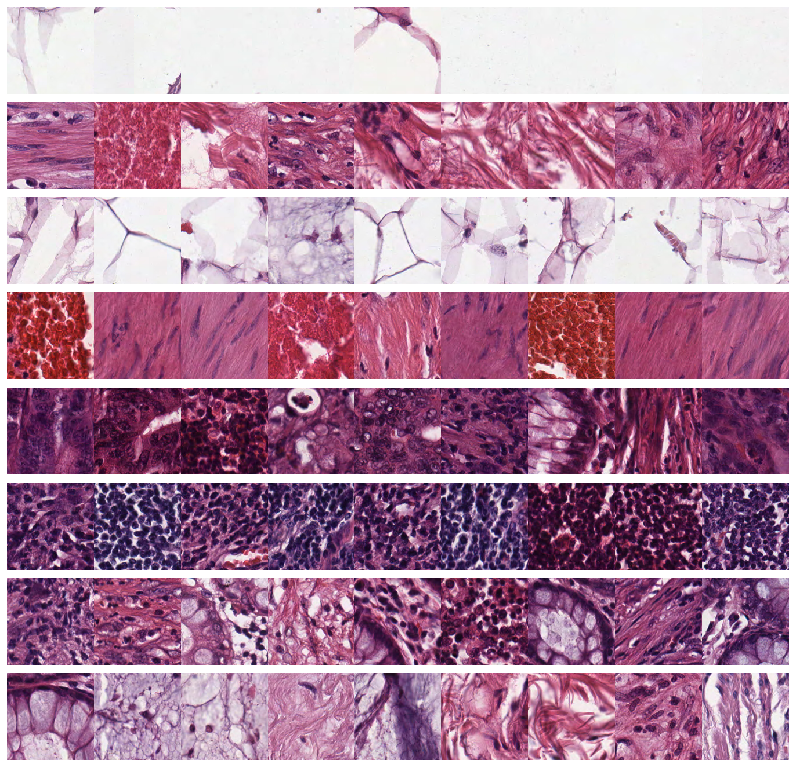

In [26]:
labels = fit_best(clf2.best_estimator_, y_test, X_train_enc, X_test_enc)
clusterintoDirectories(labels, test_directory, test_image_names)
myutils.pltPathologyClusters(labels, test_directory)

In [4]:
autoencoder = load_model('../Autoencoders/SavedModels/new_mean_squared_error_epochs300_batch64.h5') # 6 x 6 x 16
layer_name = 'conv2d_115' # 6 x 6 x 32

encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer(layer_name).output)
# autoencoder.summary()

In [5]:
X_train_enc = encoder.predict(X_train)
print(X_train_enc.shape)

(4200, 6, 6, 32)


In [6]:
X_test_enc = encoder.predict(X_test)
print(X_test.shape)

X_train_enc = X_train_enc.reshape(X_train_enc.shape[0] , -1) # Reshape for scaling
X_train_enc = StandardScaler().fit_transform(X_train_enc) # Scale

X_test_enc = X_test_enc.reshape(X_test_enc.shape[0] , -1) # Reshape for scaling
X_test_enc = StandardScaler().fit_transform(X_test_enc) # Scale

(800, 96, 96, 3)


In [7]:
# Evaluate on testing data using grid search  cv
parameters = {'covariance_type':('full', 'spherical', 'diag', 'tied'), 'n_components':[8],'random_state':[0,19,42]}
clf = GridSearchCV(GaussianMixture(), parameters, scoring=make_scorer(metrics.completeness_score))

clf.fit(X_train_enc, y_train)
print(clf.best_estimator_)
print(clf.best_score_)

parameters = {'init':('k-means++', 'random'), 'n_clusters':[8],'random_state':[0,19,42]}
clf2 = GridSearchCV(KMeans(), parameters, scoring=make_scorer(metrics.completeness_score))

clf2.fit(X_train_enc, y_train)
print(clf2.best_estimator_)
clf2.best_score_

GaussianMixture(covariance_type='diag', init_params='kmeans', max_iter=100,
                means_init=None, n_components=8, n_init=1, precisions_init=None,
                random_state=19, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)
0.542857335581645
KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300, n_clusters=8,
       n_init=10, n_jobs=None, precompute_distances='auto', random_state=19,
       tol=0.0001, verbose=0)


0.5259470165110727

In [8]:
# best estimator

gmm_best = GaussianMixture(covariance_type='diag', init_params='kmeans', max_iter=100,
                means_init=None, n_components=8, n_init=1, precisions_init=None,
                random_state=19, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None).fit(X_train_enc)

gmm_labels = gmm_best.predict(X_test_enc)
print(metrics.completeness_score(y_test,gmm_labels))


0.5691095274600257


In [9]:
print(metrics.completeness_score(y_train,gmm_best.predict(X_train_enc)))

0.5382154492324238


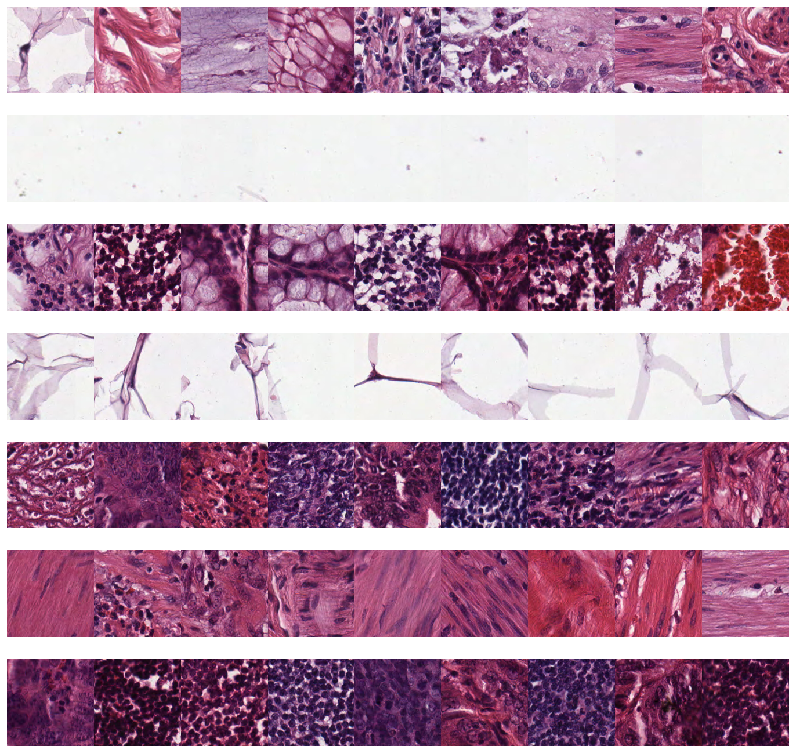

In [12]:
clusterintoDirectories(gmm_labels, test_directory, test_image_names)
myutils.pltPathologyClusters(gmm_labels, test_directory)

In [13]:
# best estimator

k_best = KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300, n_clusters=8,
       n_init=10, n_jobs=None, precompute_distances='auto', random_state=19,
       tol=0.0001, verbose=0).fit(X_train_enc)

k_labels = k_best.predict(X_test_enc)
print(metrics.completeness_score(y_test,k_labels))


0.5221734791370157


0.5221734791370157


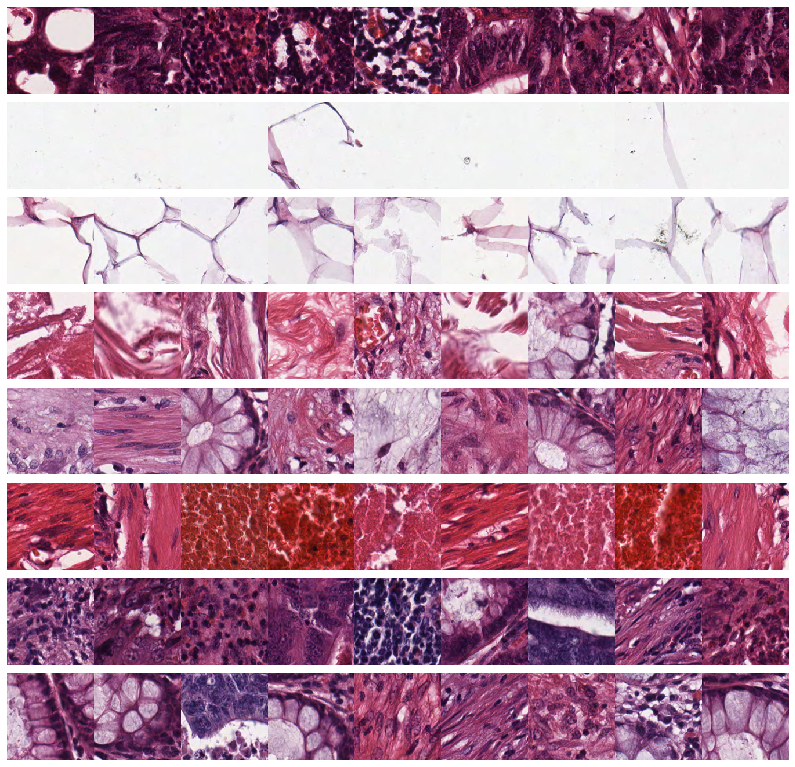

In [14]:
# best estimator

k_best = KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300, n_clusters=8,
       n_init=10, n_jobs=None, precompute_distances='auto', random_state=19,
       tol=0.0001, verbose=0).fit(X_train_enc)

k_labels = k_best.predict(X_test_enc)
print(metrics.completeness_score(y_test,k_labels))

clusterintoDirectories(k_labels, test_directory, test_image_names)
myutils.pltPathologyClusters(k_labels, test_directory)

In [15]:
# PCA 
# Reduce Dimensions
# PCA 
pca1 = PCA(n_components=150)
transformed_train = pca1.fit_transform(X_train_enc)

pca2 = PCA(n_components=150)
transformed_test = pca2.fit_transform(X_test_enc)

print(sum(pca1.explained_variance_ratio_))
print(sum(pca2.explained_variance_ratio_))
# print(pca1.n_components_)
# pca2.n_components_

0.902913327794522
0.9299359017750248


In [16]:
# Evaluate on testing data using grid search  cv
parameters = {'covariance_type':('full', 'spherical', 'diag', 'tied'), 
              'n_components':[8],'random_state':[0,19,42],"reg_covar" : [1e-5, 1e-4, 1e-6]}
clf = GridSearchCV(GaussianMixture(), parameters, scoring=make_scorer(metrics.completeness_score))

clf.fit(transformed_train, y_train)
print(clf.best_estimator_)
print(clf.best_score_)

parameters = {'init':('k-means++', 'random'), 'n_clusters':[8],'random_state':[0,19,42]}
clf2 = GridSearchCV(KMeans(), parameters, scoring=make_scorer(metrics.completeness_score))

clf2.fit(transformed_train, y_train)
print(clf2.best_estimator_)
clf2.best_score_

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Fitting the mixture model failed because some components have ill-defined empirical covariance (for instance caused by singleton or collapsed samples). Try to decrease the number of components, or increase reg_covar.

  FitFailedWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Fitting the mixture model failed because some components have ill-defined empirical covariance (for instance caused by singleton or collapsed samples). Try to decrease the number of components, or increase reg_covar.

  FitFailedWarni

GaussianMixture(covariance_type='tied', init_params='kmeans', max_iter=100,
                means_init=None, n_components=8, n_init=1, precisions_init=None,
                random_state=0, reg_covar=0.0001, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)
0.5630844292046913
KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300, n_clusters=8,
       n_init=10, n_jobs=None, precompute_distances='auto', random_state=0,
       tol=0.0001, verbose=0)


0.5216981024583414

In [17]:
# best estimator

gmm_best = GaussianMixture(covariance_type='spherical', init_params='kmeans', max_iter=100,
                means_init=None, n_components=8, n_init=1, precisions_init=None,
                random_state=19, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None).fit(transformed_train)

gmm_labels = gmm_best.predict(transformed_test)
print(metrics.completeness_score(y_test,gmm_labels))


0.4934531310403096


In [18]:
print(metrics.completeness_score(y_train,gmm_best.predict(transformed_train)))

0.5228652288127005


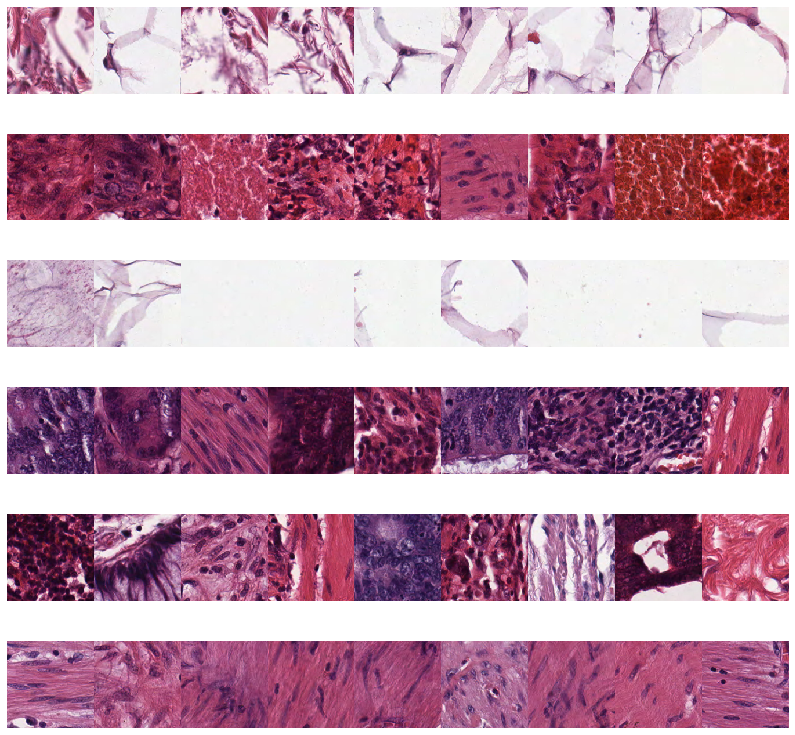

In [19]:
clusterintoDirectories(gmm_labels, test_directory, test_image_names)
myutils.pltPathologyClusters(gmm_labels, test_directory)

In [20]:
def pltPathologyClusters(labels, path):
    # clusterimgDir = "../../Data/clusters_journal.PNG"
    # image = Image.open(clusterimgDir) 
    # plt.figure(figsize = (85,12))
    # plt.imshow(image)
    # plt.axis('off')
    
    sub_directories = [str(cluster) for cluster in set(labels)]
    displayImages = []
    fig = plt.figure(figsize=(14, 14))
    
#     print(len(sub_directories))
    x=1
    
    for cluster in sub_directories:
        direct = path + '/{}'.format(cluster)
#         print(len(os.listdir(direct)))
        if len(os.listdir(direct))-9 > 9: # if directory has less than 9 images set index to 0 else random index
            index = np.random.randint(9,len(os.listdir(direct))-9)
        else:
#             print("index is 0")
            index = 0 # pick the first 10 images
        clusterList = [] # reset the row
        for file in os.listdir(direct)[index:index+9]: # random sample of 9 images
            if file.endswith('.tif'):
                image = tifffile.imread(os.path.join(path, file))
                clusterList.append(image)
                displayImages.append(image) # list of ALL Images
                
        for i in range(1,9+1):
            if (len(clusterList) > i):
                img = clusterList[i-1]
            fig.add_subplot(8, 9, x)
            plt.imshow(img)
            plt.axis('off')
            plt.subplots_adjust(wspace=0.0, hspace=0.0)
            x+=1
        
    
    
#     columns = 9
#     rows = len(sub_directories)
    
#     print(len(displayImages))
#     print(columns*rows)
    
#     for i in range(1, columns*rows+1):
#         img = displayImages[i-1]
#         fig.add_subplot(rows, columns, i)
#         plt.imshow(img)
#         plt.axis('off')
#         plt.subplots_adjust(wspace=0.0, hspace=0.0)
    plt.show()
    

0.48233862836911967
0.505129554092422


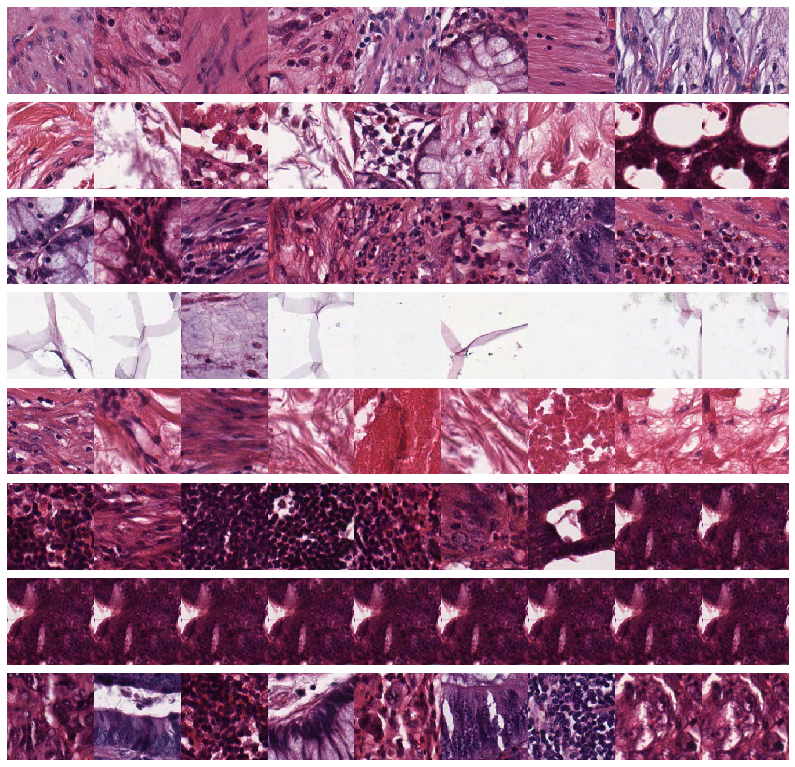

In [21]:
# best estimator

k_best = KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300, n_clusters=8,
       n_init=10, n_jobs=None, precompute_distances='auto', random_state=0,
       tol=0.0001, verbose=0).fit(transformed_train)

k_labels = k_best.predict(transformed_test)
print(metrics.completeness_score(y_test,k_labels))
print(metrics.completeness_score(y_train, k_best.predict(transformed_train)))

clusterintoDirectories(k_labels, test_directory, test_image_names)
pltPathologyClusters(k_labels, test_directory)

In [32]:
# PCA 
# Reduce Dimensions
# PCA 
pca1 = PCA(n_components=700)
transformed_train = pca1.fit_transform(X_train_enc)

pca2 = PCA(n_components=700)
transformed_test = pca2.fit_transform(X_test_enc)

print(sum(pca1.explained_variance_ratio_))
print(sum(pca2.explained_variance_ratio_))
# print(pca1.n_components_)
# pca2.n_components_

0.9399277700140374
0.9994849215127033


In [33]:
def plotdiffTsne(X):
    fig, axs = plt.subplots(2, 2, figsize=(13, 7))

    tsne2 = TSNE(n_components=2, perplexity = 30).fit_transform(X)
    kmeans2 = KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300, n_clusters=8,
       n_init=10, n_jobs=None, precompute_distances='auto', random_state=19,
       tol=0.0001, verbose=0).fit(tsne2)

    axs[0, 1].scatter(tsne2[:, 0], tsne2[:, 1], c=kmeans2.labels_, cmap='viridis')
    axs[0, 1].set_title('TSNE perplexity = 30')


    tsne4 = TSNE(n_components=2, perplexity = 90).fit_transform(X)
    kmeans4 = KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300, n_clusters=8,
       n_init=10, n_jobs=None, precompute_distances='auto', random_state=19,
       tol=0.0001, verbose=0).fit(tsne4)

    axs[1, 1].scatter(tsne4[:, 0], tsne4[:, 1], c=kmeans4.labels_, cmap='viridis')
    axs[1, 1].set_title('TSNE perplexity = 90')
    
    plt.savefig('TSNE-CAE.png')
    plt.show()

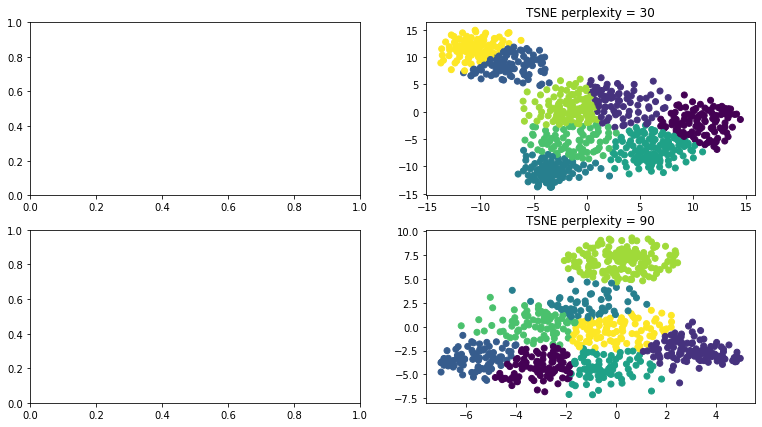

In [34]:
plotdiffTsne(transformed_test)

In [22]:
autoencoder.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
conv2d_109 (Conv2D)             (None, 96, 96, 16)   448         input_10[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_154 (LeakyReLU)     (None, 96, 96, 16)   0           conv2d_109[0][0]                 
__________________________________________________________________________________________________
conv2d_110 (Conv2D)             (None, 96, 96, 32)   4640        leaky_re_lu_154[0][0]            
___________________________________________________________________________________________